# Generative Model (Olive Oils dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


In [2]:
# import local utility functions
import sys
sys.path.append('../utils')
import utils as utl

## Load raw data and plot

In [3]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/olive_oils/FTIR_olive_oils.csv')
data.head(5)

,798.892,800.8215,802.751,804.6805,806.61,808.5395,810.469,812.3985,814.328,816.2575,...,1885.2305,1887.16,1889.0895,1891.019,1892.9485,1894.878,1896.8085,code,label,sample
0,0.127523,0.127950,0.129282,0.131174,0.133590,0.136426,0.139358,0.142219,0.144805,0.146764,...,0.012279,0.012158,0.011884,0.011716,0.011583,0.011315,0.011304,1,Greece,1
1,0.126498,0.127131,0.128511,0.130340,0.132527,0.135309,0.138353,0.141150,0.143630,0.145624,...,0.006467,0.006223,0.005720,0.005518,0.005494,0.005321,0.005426,1,Greece,1
2,0.130412,0.130675,0.132017,0.133824,0.136095,0.138944,0.141723,0.144136,0.146431,0.148389,...,0.007548,0.007391,0.007176,0.006843,0.006551,0.006398,0.006582,1,Greece,2
3,0.130022,0.130407,0.132018,0.134007,0.136271,0.138875,0.141481,0.144075,0.146553,0.148443,...,0.006059,0.005933,0.005507,0.005347,0.005349,0.005133,0.005222,1,Greece,2
4,0.128602,0.128790,0.130022,0.132012,0.134427,0.137070,0.139646,0.142338,0.144923,0.146958,...,0.010594,0.010379,0.010287,0.010127,0.009966,0.009760,0.009649,1,Greece,3


In [4]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

Greece: blue
Italy: red
Portugal: green
Spain: orange


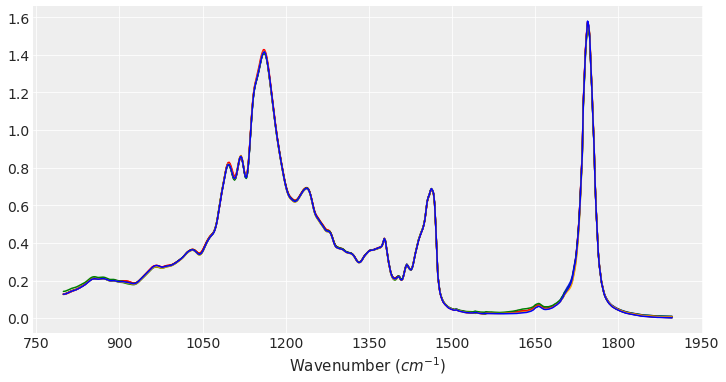

In [5]:
# name of column containing the labels
label_col = 'label'

# number of non-data columns at right of dataframe
non_data_cols = -3

# list of class labels
class_labels = utl.get_class_labels(data, label_col)

# plot dataframe
utl.plot_data(data, non_data_cols, label_col, 8)

In [6]:
#data.describe()

In [7]:
# number of samples from each class
data[label_col].value_counts()

Spain       50
Italy       34
Greece      20
Portugal    16
Name: label, dtype: int64

In [8]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [9]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(len(class_labels),len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_s[0][:len(x_s[0])])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_s[1][:len(x_s[1])])
    class_c = pm.Normal('class_c', mu=mu[2], sd=sigma, observed=x_s[2][:len(x_s[2])])
    class_d = pm.Normal('class_d', mu=mu[3], sd=sigma, observed=x_s[3][:len(x_s[3])])
    
    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:58<00:00, 42.34draws/s] 


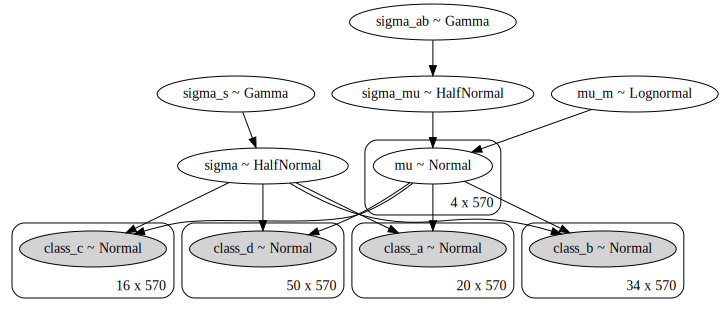

In [10]:
pm.model_to_graphviz(model_gm)

In [11]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",0.128,0.001,0.126,0.129,0.000,0.000,3334.0,3331.0,3334.0,2569.0,1.0
"mu[0,1]",0.128,0.001,0.127,0.129,0.000,0.000,4583.0,4583.0,4591.0,2724.0,1.0
"mu[0,2]",0.129,0.001,0.128,0.130,0.000,0.000,4581.0,4581.0,4586.0,2641.0,1.0
"mu[0,3]",0.131,0.001,0.130,0.132,0.000,0.000,4310.0,4310.0,4304.0,2666.0,1.0
"mu[0,4]",0.134,0.001,0.132,0.135,0.000,0.000,5368.0,5364.0,5402.0,2310.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.334,0.007,0.321,0.347,0.000,0.000,5322.0,5322.0,5314.0,2590.0,1.0
sigma_ab,0.745,0.640,0.123,1.827,0.012,0.009,2859.0,2649.0,4165.0,2964.0,1.0
sigma_mu,0.334,0.005,0.325,0.343,0.000,0.000,4843.0,4843.0,4821.0,2905.0,1.0
sigma_s,0.188,0.370,0.001,0.772,0.007,0.005,3073.0,3073.0,3381.0,3437.0,1.0


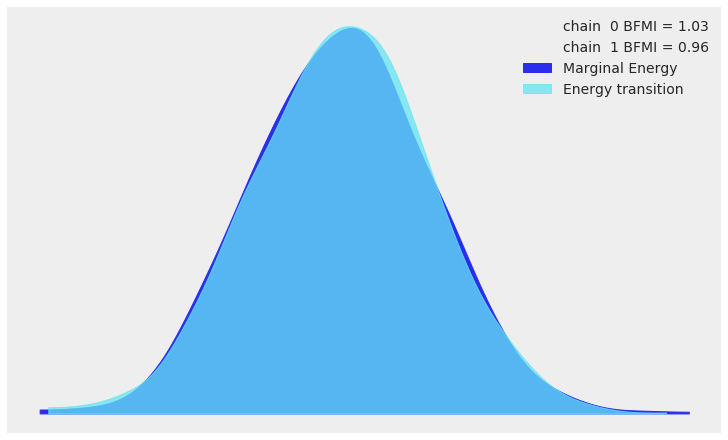

In [12]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [13]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:02<00:00, 97.12it/s] 


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


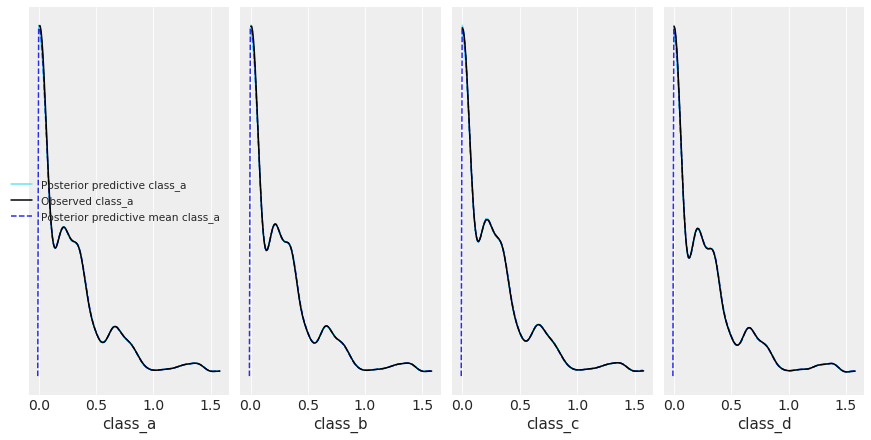

In [14]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [15]:
print(az.r2_score(x_s[0][:len(x_s[0])], ppc['class_a']))

r2        0.999914
r2_std    0.000008
dtype: float64


In [16]:
print(az.r2_score(x_s[1][:len(x_s[1])], ppc['class_b']))

r2        0.999916
r2_std    0.000007
dtype: float64


In [17]:
print(az.r2_score(x_s[2][:len(x_s[2])], ppc['class_c']))

r2        0.999912
r2_std    0.000008
dtype: float64


In [18]:
print(az.r2_score(x_s[3][:len(x_s[3])], ppc['class_d']))

r2        0.999917
r2_std    0.000007
dtype: float64


In [19]:
print(az.bfmi(trace_gm))

[1.02728496 0.95625175]


# Posterior samples vs. mean data

In [20]:
# class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']
cl_c = ppc['class_c']
cl_d = ppc['class_d']

ppc_class_lst = [cl_a, cl_b, cl_c, cl_d]

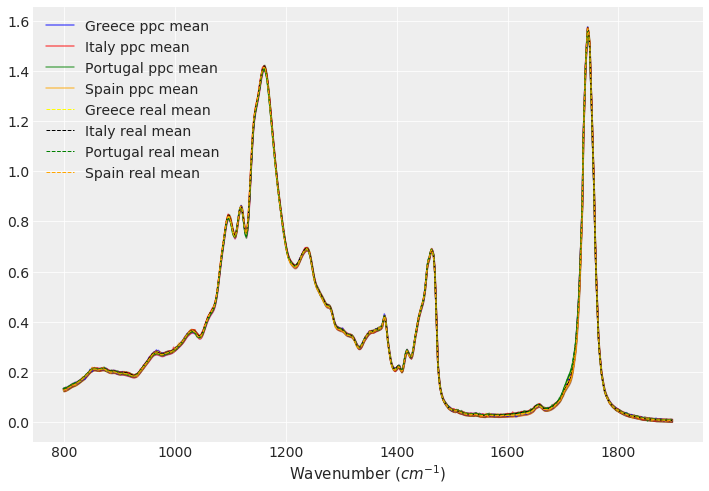

In [21]:
utl.plot_mean_vs_ppc(data, ppc_class_lst, non_data_cols, label_col)

# Real spectrum vs. posterior samples

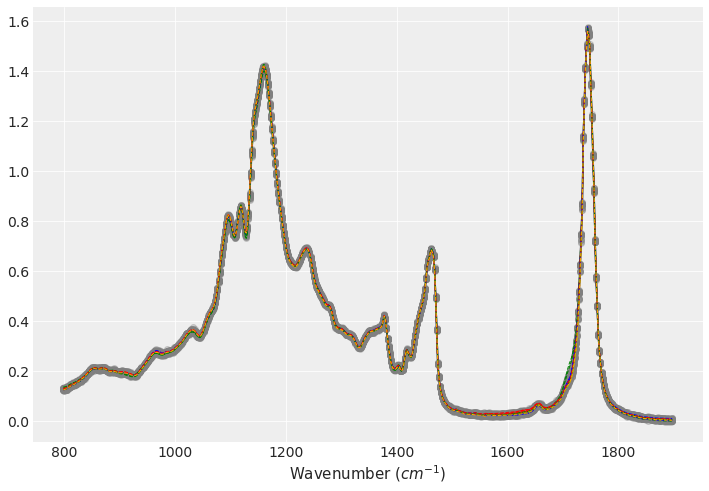

In [22]:
utl.plot_real_vs_ppc(data, ppc_class_lst, non_data_cols, label_col, 5)

# Save posterior samples to .csv file

In [23]:
x_val = utl.get_data_x_value_header(data, non_data_cols)
samples_per_class = 50
filename = './ppc_samples_olive_oils.csv' 

utl.save_traces(filename, samples_per_class, x_val, class_labels, ppc_class_lst)